# Denoising with the deep decoder and the DIP

Here, we demonstrate the denoising performance on an example image.

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os

from os import listdir
from os.path import isfile, join

import warnings
warnings.filterwarnings('ignore')

from include import *
from PIL import Image
import PIL

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable
from models import *
#from utils.denoising_utils import *


GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '1'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 1


In [2]:
def denoise(img_noisy_np,img_clean_np,net,num_channels,numit = 1900,rn = 0.0,find_best=True,upsample_mode='bilinear'):
    mse_n, mse_t, ni, net = fit( num_channels=num_channels,
                        reg_noise_std=rn,
                        num_iter=numit,
                        img_noisy_var=np_to_var(img_noisy_np).type(dtype),
                        net=net,
                        img_clean_var=np_to_var(img_clean_np).type(dtype),
                        find_best=find_best,
                        upsample_mode=upsample_mode,
                        #OPTIMIZER='SGD',LR=0.1,
                        )
    out_img_np = net( ni.type(dtype) ).data.cpu().numpy()[0]
    return out_img_np, mse_t

## Load image

In [3]:
path = './test_data/'
img_name = "astronaut"
#img_name = "mri"

img_path = path + img_name + ".png"
img_pil = Image.open(img_path)
#img_pil = load_and_crop(img_path,target_width=256,target_height=256)

img_clean_np = pil_to_np(img_pil)
img_clean_var = np_to_var(img_clean_np).type(dtype)

## Generate noisy image

In [4]:
def get_noisy_img(img_np,sig=25.0,noise_same = True):
    sigma = sig/255.
    if noise_same: # add the same noise in each channel
        noise = np.random.normal(scale=sigma, size=img_np.shape[1:])
        noise = np.array( [noise]*img_np.shape[0] )
    else: # add independent noise in each channel
        noise = np.random.normal(scale=sigma, size=img_np.shape)
    
    img_noisy_np = np.clip( img_np + noise , 0, 1).astype(np.float32)
    #img_noisy_var = np_to_var(img_noisy_np).type(dtype)
    return img_noisy_np #,img_noisy_var

##  Get image, noise, and noisy image

In [5]:
sig = 30.0
noise_same = False
img_noisy_np = get_noisy_img(img_clean_np,sig,noise_same)

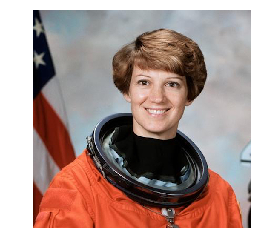

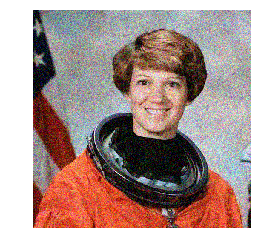

1.0


In [6]:
def myimgshow(plt,img):
    if(img.shape[0] == 1):
        plt.imshow(np.clip(img[0],0,1),cmap='Greys',interpolation='none')
    else:
        plt.imshow(np.clip(img.transpose(1, 2, 0),0,1),interpolation='none')
    plt.axis('off')
        
myimgshow(plt,img_clean_np)
plt.show()
myimgshow(plt,img_noisy_np)
plt.show()

print(np.max(img_noisy_np))

## DIP

input shape:  [1, 32, 512, 512]
optimize with adam 0.01


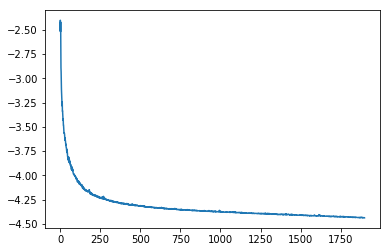

In [7]:
img = img_noisy_np

output_depth = img.shape[0]
net = get_net(32, 'skip', 'reflection',n_channels=output_depth,skip_n33d=128,
              skip_n33u=128,skip_n11=4,num_scales=5,upsample_mode='bilinear').type(dtype)
num_channels = [32]*5

out_img_np, mse_t_clean = denoise(img,img,net,num_channels=num_channels,rn=1./30.,numit = 1900,upsample_mode="none")
plt.plot(np.log(mse_t_clean))

## Deep Decoder overparameterized

input shape:  [1, 512, 16, 16]
optimize with adam 0.01


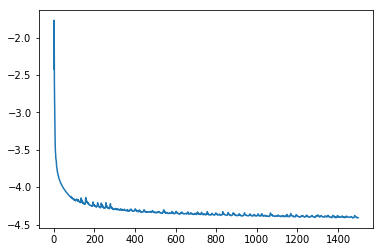

In [8]:
num_channels = [512]*5
#num_channels = [384]*5

net = decodernw(output_depth,num_channels_up=num_channels,upsample_first=True).type(dtype)
out_img_np_ddo, mse_t_clean = denoise(img,img,net,num_channels=num_channels,numit = 1500) 

plt.plot(np.log(mse_t_clean))

## Deep Decoder 

input shape:  [1, 128, 16, 16]
optimize with adam 0.01


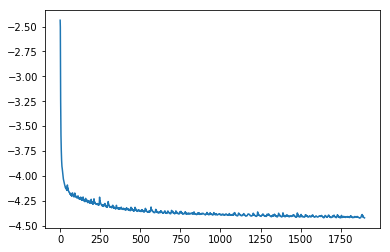

In [9]:
num_channels = [128]*5

net = decodernw(output_depth,num_channels_up=num_channels,upsample_first=False).type(dtype)
out_img_np_dd, mse_t_clean = denoise(img,img,net,num_channels=num_channels,numit = 1900) 

plt.plot(np.log(mse_t_clean))

## Plot & save

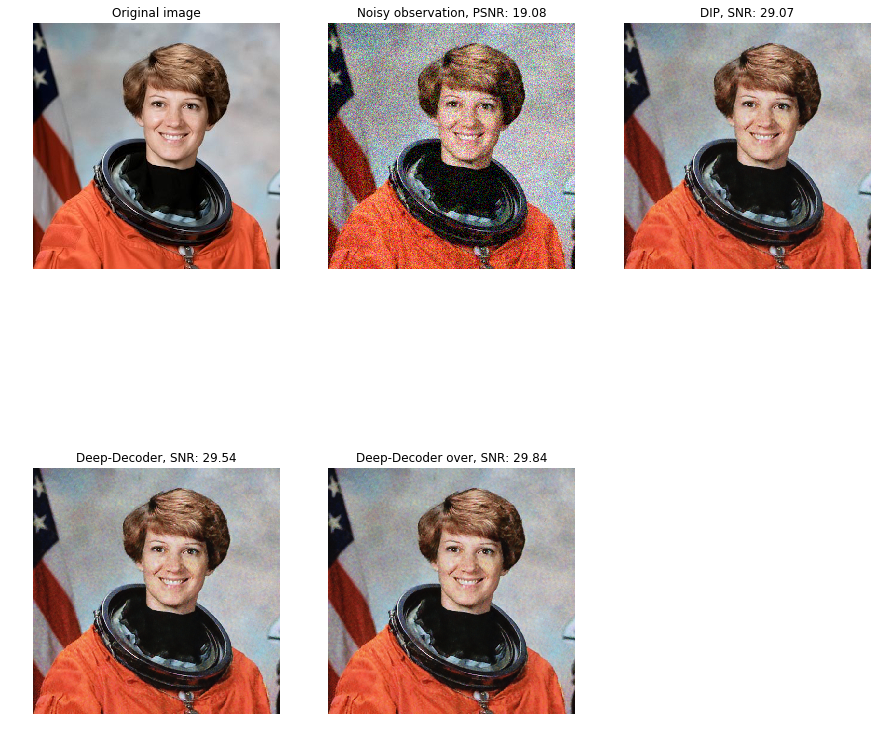

In [10]:
def plot_results():
    fig = plt.figure(figsize = (15,15)) # create a 5 x 5 figure 
    
    ax1 = fig.add_subplot(231)
    myimgshow(ax1,img_clean_np) 
    ax1.set_title('Original image')
    ax1.axis('off')
    
    ax2 = fig.add_subplot(232)
    myimgshow(ax2,img_noisy_np)
    ax2.set_title( "Noisy observation, PSNR: %.2f" % psnr(img_clean_np,img_noisy_np) )
    ax2.axis('off')

    ax3 = fig.add_subplot(233)
    myimgshow(ax3,out_img_np)
    ax3.set_title( "DIP, SNR: %.2f" % psnr(img_clean_np,out_img_np) ) 
    ax3.axis('off')
    
    ax4 = fig.add_subplot(234)
    myimgshow(ax4,out_img_np)
    ax4.set_title( "Deep-Decoder, SNR: %.2f" % psnr(img_clean_np,out_img_np_dd) )
    ax4.axis('off') 
    
    ax5 = fig.add_subplot(235)
    myimgshow(ax5,out_img_np)
    ax5.set_title( "Deep-Decoder over, SNR: %.2f" % psnr(img_clean_np,out_img_np_ddo) ) 
    ax5.axis('off') 

    plt.show()
    
plot_results()

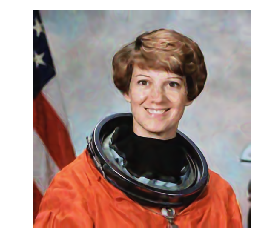

In [11]:
def savefig(filename,img):
    plt.imshow(np.clip(img.transpose(1, 2, 0),0,1),interpolation='none')
    #plt.imshow(img,cmap='gray')
    plt.axis('off')
    plt.savefig(filename,bbox_inches='tight')
    
savefig(img_name + "_orig.png",img_clean_np)
savefig(img_name + "_noisy.png",img_noisy_np)
savefig(img_name + "_DIP.png",out_img_np)
savefig(img_name + "_DD.png",out_img_np_dd)
savefig(img_name + "_DDO.png",out_img_np_ddo)